# Data preparation

Prepare data for further processing.
Steps:
- discretizing data (temporal and spatial)
- encoding of categorical values
- dropping of not necessary columns
- persisting the prepared dataset as 'trips_prepared.hdf5'


In [2]:
import vaex

Load dataset

In [3]:
df_trips = vaex.open("data/trips/trips.hdf5")

In [4]:
df_trips.info()

column,type,unit,description,expression
Trip ID,str,,,
Taxi ID,str,,,
Trip Start Timestamp,str,,,
Trip End Timestamp,str,,,
Trip Seconds,float64,,,
Trip Miles,float64,,,
Pickup Census Tract,float64,,,
Dropoff Census Tract,float64,,,
Pickup Community Area,float64,,,
Dropoff Community Area,float64,,,


## Discretize Data

Temporal 

In [5]:
import numpy as np
from datetime import datetime

def convert_to_datetime(date_string):
    return np.datetime64(datetime.strptime(str(date_string), "%m/%d/%Y %I:%M:%S %p"))

df_trips['ts_start']  = df_trips["Trip Start Timestamp"].apply(convert_to_datetime)

In [6]:
# add hourly data including cyclical features for periodically occurring features (hours, days)
# cyclical features are projected to a circle to ensure equal distances between hours or week days when the day or week changes (12 am -> 1 am or sunday -> monday)
df_trips['ts_start_1_hour']     = df_trips['ts_start'].dt.hour
df_trips['ts_start_1_hour_sin'] = np.sin(df_trips['ts_start_1_hour']*(2.*np.pi/24))
df_trips['ts_start_1_hour_cos'] = np.cos(df_trips['ts_start_1_hour']*(2.*np.pi/24))
df_trips['ts_start_4_hour']     = df_trips['ts_start'].dt.floor('4h').dt.hour
df_trips['ts_start_4_hour_sin'] = np.sin(df_trips['ts_start_4_hour']*(2.*np.pi/6))
df_trips['ts_start_4_hour_cos'] = np.cos(df_trips['ts_start_4_hour']*(2.*np.pi/6))
df_trips['ts_start_6_hour']     = df_trips['ts_start'].dt.floor('6h').dt.hour
df_trips['ts_start_6_hour_sin'] = np.sin(df_trips['ts_start_6_hour']*(2.*np.pi/4))
df_trips['ts_start_6_hour_cos'] = np.cos(df_trips['ts_start_6_hour']*(2.*np.pi/4))

df_trips['ts_start_day']       = df_trips['ts_start'].dt.date
df_trips['start_weekday']      = df_trips['ts_start'].dt.dayofweek
df_trips['start_weekday_sin']  = np.sin(df_trips['start_weekday']*(2.*np.pi/7))
df_trips['start_weekday_cos']  = np.cos(df_trips['start_weekday']*(2.*np.pi/7))
df_trips['start_month']        = df_trips['ts_start'].dt.month

Exemplary scatter plots of the cyclical features (ts_start_1_hour and start_weekday)

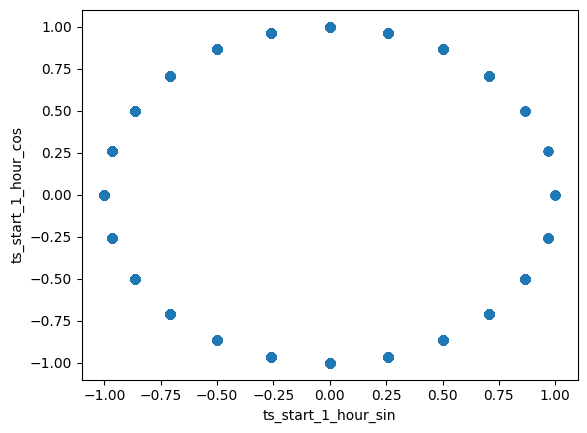

In [7]:
# exemplary plot of the cyclical feature of ts_start_1_hour
df_trips[:5000].viz.scatter(df_trips['ts_start_1_hour_sin'], df_trips['ts_start_1_hour_cos']) 

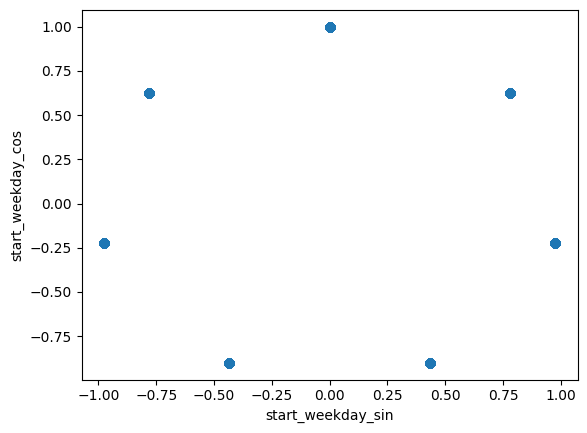

In [8]:
# exemplary plot of the cyclical feature of start_weekday
df_trips[:5000].viz.scatter(df_trips['start_weekday_sin'], df_trips['start_weekday_cos']) 

Spatial

In [9]:
import h3
from shapely import Polygon 

# docu resolution https://h3geo.org/docs/core-library/restable/

def convert_to_hex_id (lat, lon, resolution):
        hex_id = h3.geo_to_h3(lat, lon, resolution)
        return hex_id if hex_id != "0" else None

def convert_hex_to_polygon(hex):
        polygon = None
        if hex:
               polygon = Polygon(h3.h3_to_geo_boundary(hex, geo_json=True))         
        return polygon


In [10]:
# define multiple convert functions, since vaex_df.apply() only supports column arguments

def convert_to_hex_id_7 (lat, lon):
    return convert_to_hex_id (lat, lon, 7)
def convert_to_hex_id_8 (lat, lon):
    return convert_to_hex_id (lat, lon, 8)
def convert_to_hex_id_9 (lat, lon):
    return convert_to_hex_id (lat, lon, 9)


In [11]:
df_trips['pickup_hex_7']  = df_trips.apply(convert_to_hex_id_7, arguments=[df_trips['Pickup Centroid Latitude'],  df_trips['Pickup Centroid Latitude']])
df_trips['dropoff_hex_7'] = df_trips.apply(convert_to_hex_id_7, arguments=[df_trips['Dropoff Centroid Latitude'], df_trips['Dropoff Centroid Latitude']])
df_trips['pickup_hex_8']  = df_trips.apply(convert_to_hex_id_8, arguments=[df_trips['Pickup Centroid Latitude'],  df_trips['Pickup Centroid Latitude']])
df_trips['dropoff_hex_8'] = df_trips.apply(convert_to_hex_id_8, arguments=[df_trips['Dropoff Centroid Latitude'], df_trips['Dropoff Centroid Latitude']])
df_trips['pickup_hex_9']  = df_trips.apply(convert_to_hex_id_9, arguments=[df_trips['Pickup Centroid Latitude'],  df_trips['Pickup Centroid Latitude']])
df_trips['dropoff_hex_9'] = df_trips.apply(convert_to_hex_id_9, arguments=[df_trips['Dropoff Centroid Latitude'], df_trips['Dropoff Centroid Latitude']])

In [12]:
df_trips['pickup_pol_7']  = df_trips['pickup_hex_7'].apply(convert_hex_to_polygon)
df_trips['dropoff_pol_7'] = df_trips['dropoff_hex_7'].apply(convert_hex_to_polygon)
df_trips['pickup_pol_8']  = df_trips['pickup_hex_8'].apply(convert_hex_to_polygon) 
df_trips['dropoff_pol_8'] = df_trips['dropoff_hex_8'].apply(convert_hex_to_polygon)
df_trips['pickup_pol_9']  = df_trips['pickup_hex_9'].apply(convert_hex_to_polygon) 
df_trips['dropoff_pol_9'] = df_trips['dropoff_hex_9'].apply(convert_hex_to_polygon)

## Analysis of string attribute sizes, lengths etc. Encoding of string categorical values for further processing

In [14]:
len(df_trips['Payment Type'].unique())

7

In [15]:
df_trips['Payment Type'].unique()

['Dispute', 'Unknown', 'Prcard', 'Cash', 'Credit Card', 'Pcard', 'No Charge']

In [16]:
len(df_trips['Company'].unique())

108

In [17]:
df_trips['Company'].unique()

['3556 - 36214 RC Andrews Cab',
 None,
 '3094 - G.L.B. Cab Co',
 '2823 - Seung Lee',
 '4787 - Reny Cab Co',
 '5074 - 54002 Ahzmi Inc',
 '3897 - 57856 Ilie Malec',
 '0118 - 42111 Godfrey S.Awir',
 '3253 - 91138 Gaither Cab Co.',
 'Blue Ribbon Taxi Association Inc.',
 '585 - Valley Cab Co',
 '4732 - Maude Lamy',
 'Blue Diamond',
 '3385 - Eman Cab',
 '4615 - 83503 Tyrone Henderson',
 'Northwest Management LLC',
 '2733 - Benny Jona',
 '4053 - Adwar H. Nikola',
 '2192 - Zeymane Corp',
 '2767 - Sayed M Badri',
 '1408 - Donald Barnes',
 '4787 - 56058 Reny Cab Co',
 'nan',
 'Flash Cab',
 '3620 - David K. Cab Corp.',
 '6488 - Zuha Taxi',
 '4053 - 40193 Adwar H. Nikola',
 '6743 - 78771 Luhak Corp',
 'Taxi Affiliation Services',
 'Chicago Medallion Management',
 "3591- 63480 Chuk's Cab",
 'Suburban Dispatch LLC',
 '1408 - 89599 Donald Barnes',
 '3385 - 23210  Eman Cab',
 'Chicago Elite Cab Corp. (Chicago Carriag',
 '3623 - 72222 Arrington Enterprises',
 '0694 - 59280 Chinesco Trans Inc',
 '5874 -

In [18]:
len(df_trips['Taxi ID'].unique())

7781

In [19]:
df_trips['Taxi ID'].apply(lambda x : len(x) if x != None else 0).mean()

array(127.99877803)

Encode string columns

In [20]:
def generate_encoding_dict(df, column):
    # get categories to encode
    categories = df[column].unique()
    # generate output the categories are mapped to -> using a simple integer mapping 
    output = range(len(categories))
    # combine categories and output
    encoding_dict = dict(zip(categories, output))
    return encoding_dict

In [21]:
df_trips['Payment Type_encoded'] = df_trips['Payment Type'].map(generate_encoding_dict(df_trips, 'Payment Type'))
df_trips['Company_encoded']      = df_trips['Company'].map(generate_encoding_dict(df_trips, 'Company'))
df_trips['Taxi ID_encoded']      = df_trips['Taxi ID'].map(generate_encoding_dict(df_trips, 'Taxi ID'))

In [22]:
def transpose_category(df, column_name, category):
    df[column_name + '_' + category] = df[column_name].apply(lambda x: 1 if x == category else 0)

In [23]:
categories = df_trips['Payment Type'].unique()
for category in categories:
    transpose_category(df_trips, 'Payment Type', category)

In [24]:
df_trips

#,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,ts_start,ts_start_1_hour,ts_start_1_hour_sin,ts_start_1_hour_cos,ts_start_4_hour,ts_start_4_hour_sin,ts_start_4_hour_cos,ts_start_6_hour,ts_start_6_hour_sin,ts_start_6_hour_cos,ts_start_day,start_weekday,start_weekday_sin,start_weekday_cos,start_month,pickup_hex_7,dropoff_hex_7,pickup_hex_8,dropoff_hex_8,pickup_hex_9,dropoff_hex_9,pickup_pol_7,dropoff_pol_7,pickup_pol_8,dropoff_pol_8,pickup_pol_9,dropoff_pol_9,Payment Type_encoded,Company_encoded,Taxi ID_encoded,Payment Type_Dispute,Payment Type_Unknown,Payment Type_Prcard,Payment Type_Cash,Payment Type_Credit Card,Payment Type_Pcard,Payment Type_No Charge
0,506646dd0685bd55094f1b7dfac97cf3b07b6126,'1099c684f9da1ac1d0dd253d394f1c8dad37bc1a53d944d...,05/17/2014 10:45:00 AM,05/17/2014 11:00:00 AM,1080.0,7.0,17031281900.0,17031061100.0,28.0,6.0,17.45,0.0,0.0,1.5,18.95,Cash,Taxi Affiliation Services,41.879255084,-87.642648998,POINT (-87.642648998 41.8792550844),41.949139771,-87.656803909,POINT (-87.6568039088 41.9491397709),2014-05-17 10:45:00.000000,10,0.5000000000000003,-0.8660254037844385,8,0.8660254037844392,-0.4999999999999992,6,3.6739403974420594e-16,-1.0,2014-05-17,5,-0.9749279121818236,-0.2225209339563146,5,872c21191ffffff,872c2118bffffff,882c211913fffff,882c2118bbfffff,892c211913bffff,892c2118ba3ffff,"'<POLYGON ((41.859 41.887, 41.856 41.875, 41.869...","'<POLYGON ((41.936 41.95, 41.933 41.937, 41.945 ...","'<POLYGON ((41.878 41.886, 41.875 41.882, 41.878...","'<POLYGON ((41.946 41.953, 41.942 41.949, 41.946...","'<POLYGON ((41.877 41.881, 41.876 41.879, 41.878...","'<POLYGON ((41.947 41.95, 41.947 41.948, 41.948 ...",3,28,338,0,0,0,1,0,0,0
1,1462669f59c3b5a1730e8a5f511a4102d1998c21,'379e0fd9da136cabc9eec3aca37047bbdee373ca2ef7a03...,04/17/2014 06:30:00 PM,04/17/2014 07:00:00 PM,1080.0,3.0,nan,17031841100.0,nan,34.0,11.45,0.0,0.0,1.0,12.45,Cash,Taxi Affiliation Services,nan,nan,--,41.851017824,-87.635091856,POINT (-87.6350918563 41.8510178239),2014-04-17 18:30:00.000000,18,-1.0,-1.8369701987210297e-16,16,-0.8660254037844377,-0.5000000000000016,18,1.102182119232618e-15,-1.0,2014-04-17,3,0.43388373911755823,-0.900968867902419,4,None,872c21190ffffff,None,882c211905fffff,None,892c211905bffff,None,"'<POLYGON ((41.84 41.871, 41.837 41.859, 41.849 ...",None,"'<POLYGON ((41.85 41.858, 41.846 41.854, 41.849 ...",None,"'<POLYGON ((41.848 41.853, 41.848 41.851, 41.849...",3,28,4709,0,0,0,1,0,0,0
2,8d699aec32ce70e3647f7b06147001d3926975cc,'6768c7ebfdee8e7e7b3f5ec44739316241895aa2f7edf10...,05/03/2014 11:30:00 PM,05/03/2014 11:45:00 PM,720.0,2.1,17031081800.0,17031081403.0,8.0,8.0,8.45,2.0,0.0,1.0,11.45,Credit Card,Dispatch Taxi Affiliation,41.89321636,-87.63784421,POINT (-87.6378442095 41.8932163595),41.890922026,-87.618868355,POINT (-87.6188683546 41.8909220259),2014-05-03 23:30:00.000000,23,-0.25881904510252157,0.9659258262890681,20,0.8660254037844403,-0.4999999999999972,18,1.102182119232618e-15,-1.0,2014-05-03,5,-0.9749279121818236,-0.2225209339563146,5,872c2119cffffff,872c2119cffffff,882c2119c1fffff,882c2119c1fffff,892c2119c0fffff,892c2119c0bffff,"'<POLYGON ((41.879 41.903, 41.875 41.89, 41.888 ...","'<POLYGON ((41.879 41.903, 41.875 41.89, 41.888 ...","'<POLYGON ((41.888 41.898, 41.885 41.894, 41.888...","'<POLYGON ((41.888 41.898, 41.885 41.894, 41.888...","'<POLYGON ((41.893 41.894, 41.893 41.892, 41.895...","'<POLYGON ((41.891 41.892, 41.89 41.89, 41.892 4...",4,50,1596,0,0,0,0,1,0,0
3,ae05f6f7a766b58b059f04c7549892da4dc3cf54,'7dc01f4be54a4058ffb81098be25f52c9f1249afc88e3ef...,05/17/2014 01:30:00 AM,05/17/2014 01:45:00 AM,480.0,0.0,17031071500.0,17031062200.0,7.0,6.0,7.85,3.0,0.0,1.0,11.85,Credit Card,Tax

## Drop redundant and not needed columns

Location data is present in different formats. Latitude and Longitude are used in the further processing.
The Trip End Timestamp is dropped as well since the start timestamp and Trip duration are sufficient for the further processing

In [25]:
df_trips.drop(['Pickup Census Tract','Dropoff Census Tract','Pickup Community Area', 'Dropoff Community Area', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Pickup Centroid Location', 'Dropoff Centroid  Location', 'Trip End Timestamp'], inplace=True)

#,Trip ID,Taxi ID,Trip Start Timestamp,Trip Seconds,Trip Miles,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,ts_start,ts_start_1_hour,ts_start_1_hour_sin,ts_start_1_hour_cos,ts_start_4_hour,ts_start_4_hour_sin,ts_start_4_hour_cos,ts_start_6_hour,ts_start_6_hour_sin,ts_start_6_hour_cos,ts_start_day,start_weekday,start_weekday_sin,start_weekday_cos,start_month,pickup_hex_7,dropoff_hex_7,pickup_hex_8,dropoff_hex_8,pickup_hex_9,dropoff_hex_9,pickup_pol_7,dropoff_pol_7,pickup_pol_8,dropoff_pol_8,pickup_pol_9,dropoff_pol_9,Payment Type_encoded,Company_encoded,Taxi ID_encoded,Payment Type_Dispute,Payment Type_Unknown,Payment Type_Prcard,Payment Type_Cash,Payment Type_Credit Card,Payment Type_Pcard,Payment Type_No Charge
0,506646dd0685bd55094f1b7dfac97cf3b07b6126,'1099c684f9da1ac1d0dd253d394f1c8dad37bc1a53d944d...,05/17/2014 10:45:00 AM,1080.0,7.0,17.45,0.0,0.0,1.5,18.95,Cash,Taxi Affiliation Services,2014-05-17 10:45:00.000000,10,0.5000000000000003,-0.8660254037844385,8,0.8660254037844392,-0.4999999999999992,6,3.6739403974420594e-16,-1.0,2014-05-17,5,-0.9749279121818236,-0.2225209339563146,5,872c21191ffffff,872c2118bffffff,882c211913fffff,882c2118bbfffff,892c211913bffff,892c2118ba3ffff,"'<POLYGON ((41.859 41.887, 41.856 41.875, 41.869...","'<POLYGON ((41.936 41.95, 41.933 41.937, 41.945 ...","'<POLYGON ((41.878 41.886, 41.875 41.882, 41.878...","'<POLYGON ((41.946 41.953, 41.942 41.949, 41.946...","'<POLYGON ((41.877 41.881, 41.876 41.879, 41.878...","'<POLYGON ((41.947 41.95, 41.947 41.948, 41.948 ...",3,28,338,0,0,0,1,0,0,0
1,1462669f59c3b5a1730e8a5f511a4102d1998c21,'379e0fd9da136cabc9eec3aca37047bbdee373ca2ef7a03...,04/17/2014 06:30:00 PM,1080.0,3.0,11.45,0.0,0.0,1.0,12.45,Cash,Taxi Affiliation Services,2014-04-17 18:30:00.000000,18,-1.0,-1.8369701987210297e-16,16,-0.8660254037844377,-0.5000000000000016,18,1.102182119232618e-15,-1.0,2014-04-17,3,0.43388373911755823,-0.900968867902419,4,None,872c21190ffffff,None,882c211905fffff,None,892c211905bffff,None,"'<POLYGON ((41.84 41.871, 41.837 41.859, 41.849 ...",None,"'<POLYGON ((41.85 41.858, 41.846 41.854, 41.849 ...",None,"'<POLYGON ((41.848 41.853, 41.848 41.851, 41.849...",3,28,4709,0,0,0,1,0,0,0
2,8d699aec32ce70e3647f7b06147001d3926975cc,'6768c7ebfdee8e7e7b3f5ec44739316241895aa2f7edf10...,05/03/2014 11:30:00 PM,720.0,2.1,8.45,2.0,0.0,1.0,11.45,Credit Card,Dispatch Taxi Affiliation,2014-05-03 23:30:00.000000,23,-0.25881904510252157,0.9659258262890681,20,0.8660254037844403,-0.4999999999999972,18,1.102182119232618e-15,-1.0,2014-05-03,5,-0.9749279121818236,-0.2225209339563146,5,872c2119cffffff,872c2119cffffff,882c2119c1fffff,882c2119c1fffff,892c2119c0fffff,892c2119c0bffff,"'<POLYGON ((41.879 41.903, 41.875 41.89, 41.888 ...","'<POLYGON ((41.879 41.903, 41.875 41.89, 41.888 ...","'<POLYGON ((41.888 41.898, 41.885 41.894, 41.888...","'<POLYGON ((41.888 41.898, 41.885 41.894, 41.888...","'<POLYGON ((41.893 41.894, 41.893 41.892, 41.895...","'<POLYGON ((41.891 41.892, 41.89 41.89, 41.892 4...",4,50,1596,0,0,0,0,1,0,0
3,ae05f6f7a766b58b059f04c7549892da4dc3cf54,'7dc01f4be54a4058ffb81098be25f52c9f1249afc88e3ef...,05/17/2014 01:30:00 AM,480.0,0.0,7.85,3.0,0.0,1.0,11.85,Credit Card,Taxi Affiliation Services,2014-05-17 01:30:00.000000,1,0.25881904510252074,0.9659258262890683,0,0.0,1.0,0,0.0,1.0,2014-05-17,5,-0.9749279121818236,-0.2225209339563146,5,872c2119dffffff,872c2118bffffff,882c2119d3fffff,882c2118b9fffff,892c2119d33ffff,892c2118b8bffff,"'<POLYGON ((41.898 41.918, 41.894 41.906, 41.907...","'<POLYGON ((41.936 41.95, 41.933 41.937, 41.945 ...","'<POLYGON ((41.917 41.917, 41.914 41.913, 41.917...","'<POLYGON ((41.936 41.95, 41.933 41.946, 41.936 ...","'<POLYGON ((41.914 41.915, 41.914 41.913, 41.915...","'<POLYGON ((41.939 41.944, 41.938 41.942, 41.94 ...",4,28,6881,0,0,0,0,1,0,0
4,b45b42620c3a926ea633b9115dc624a33dcf3b56,'9f87b11be025b5dcc55e9472b8c2158664c97d193cf15d9...,04/25/2014 02:30:00 PM,0.0,0.0,42.05,7.0,0.0,0.0,49.05,Credit Card,T.A.S. - Payment Only,2014-04-25 14:30:00.00

## Final dataset

In [26]:
df_trips.info()

column,type,unit,description,expression
Trip ID,str,,,
Taxi ID,str,,,
Trip Start Timestamp,str,,,
Trip Seconds,float64,,,
Trip Miles,float64,,,
Fare,float64,,,
Tips,float64,,,
Tolls,float64,,,
Extras,float64,,,
Trip Total,float64,,,


## Persist dataset as 'trips_prepared.hdf5'

In [14]:
df_trips.export_hdf5("data/trips/trips_prepared.hdf5", progress=True)

export(hdf5) [########################################] 98.90% estimated time:    30.52s =  0.5m =  0.0h                                                                                          

In [44]:
# just to stop you from executing the stuff below ;)
# 
input()

''

## Persist aggregated data sets (relevant for further processing)

In [34]:
aggregation = { 'demand':'count',
                'Trip Seconds':'mean', 
                'Trip Miles':'mean', 
                'Fare':'mean', 
                'Tips':'mean', 
                'Tolls':'mean', 
                'Extras':'mean', 
                'Trip Total':'mean',
                'Company_encoded':'nunique',
                'Taxi ID_encoded':'nunique',
                'Payment Type_Dispute':'sum',
                'Payment Type_Unknown':'sum',
                'Payment Type_Prcard':'sum',
                'Payment Type_Cash':'sum',
                'Payment Type_Credit Card':'sum',
                'Payment Type_Pcard':'sum',
                'Payment Type_No Charge':'sum'}

In [43]:
# 1_hour_hex
df_trips[:100].groupby(by=[df_trips.ts_start_1_hour, df_trips.ts_start_1_hour_sin, df_trips.ts_start_1_hour_cos, df_trips.pickup_hex_7], progress=True).agg(aggregation)
df_trips[:100].groupby(by=[df_trips.ts_start_1_hour, df_trips.ts_start_1_hour_sin, df_trips.ts_start_1_hour_cos, df_trips.pickup_hex_8], progress=True).agg(aggregation)
df_trips[:100].groupby(by=[df_trips.ts_start_1_hour, df_trips.ts_start_1_hour_sin, df_trips.ts_start_1_hour_cos, df_trips.pickup_hex_9], progress=True).agg(aggregation)
# 4_hour_hex
df_trips[:100].groupby(by=[df_trips.ts_start_4_hour, df_trips.ts_start_4_hour_sin, df_trips.ts_start_4_hour_cos, df_trips.pickup_hex_7], progress=True).agg(aggregation)
df_trips[:100].groupby(by=[df_trips.ts_start_4_hour, df_trips.ts_start_4_hour_sin, df_trips.ts_start_4_hour_cos, df_trips.pickup_hex_8], progress=True).agg(aggregation)
df_trips[:100].groupby(by=[df_trips.ts_start_4_hour, df_trips.ts_start_4_hour_sin, df_trips.ts_start_4_hour_cos, df_trips.pickup_hex_9], progress=True).agg(aggregation)
# 6_hour_hex
df_trips[:100].groupby(by=[df_trips.ts_start_6_hour, df_trips.ts_start_6_hour_sin, df_trips.ts_start_6_hour_cos, df_trips.pickup_hex_7], progress=True).agg(aggregation)
df_trips[:100].groupby(by=[df_trips.ts_start_6_hour, df_trips.ts_start_6_hour_sin, df_trips.ts_start_6_hour_cos, df_trips.pickup_hex_8], progress=True).agg(aggregation)
df_trips[:100].groupby(by=[df_trips.ts_start_6_hour, df_trips.ts_start_6_hour_sin, df_trips.ts_start_6_hour_cos, df_trips.pickup_hex_9], progress=True).agg(aggregation)
# day_hex
df_trips[:100].groupby(by=[df_trips.ts_start_day, df_trips.start_weekday, df_trips.start_month, df_trips.pickup_hex_7], progress=True).agg(aggregation)
df_trips[:100].groupby(by=[df_trips.ts_start_day, df_trips.start_weekday, df_trips.start_month, df_trips.pickup_hex_8], progress=True).agg(aggregation)
df_trips[:100].groupby(by=[df_trips.ts_start_day, df_trips.start_weekday, df_trips.start_month, df_trips.pickup_hex_9], progress=True).agg(aggregation)
# weekday_hex
df_trips[:100].groupby(by=[df_trips.start_weekday, df_trips.start_weekday_sin, df_trips.start_weekday_cos, df_trips.pickup_hex_7], progress=True).agg(aggregation)
df_trips[:100].groupby(by=[df_trips.start_weekday, df_trips.start_weekday_sin, df_trips.start_weekday_cos, df_trips.pickup_hex_8], progress=True).agg(aggregation)
df_trips[:100].groupby(by=[df_trips.start_weekday, df_trips.start_weekday_sin, df_trips.start_weekday_cos, df_trips.pickup_hex_9], progress=True).agg(aggregation)
# month_hex
df_trips[:100].groupby(by=[df_trips.start_month, df_trips.pickup_hex_7], progress=True).agg(aggregation)
df_trips[:100].groupby(by=[df_trips.start_month, df_trips.pickup_hex_8], progress=True).agg(aggregation)
df_trips[:1000].groupby(by=[df_trips.start_month, df_trips.pickup_hex_9], progress=True).agg(aggregation)

groupby [########################################] 100.00% elapsed time  :     0.20s =  0.0m =  0.0h
groupby [########################################] 100.00% elapsed time  :     0.35s =  0.0m =  0.0h
groupby [########################################] 100.00% elapsed time  :     0.18s =  0.0m =  0.0h
groupby [########################################] 100.00% elapsed time  :     0.33s =  0.0m =  0.0h
groupby [########################################] 100.00% elapsed time  :     0.16s =  0.0m =  0.0h
groupby [########################################] 100.00% elapsed time  :     0.35s =  0.0m =  0.0h
groupby [########################################] 100.00% elapsed time  :     0.29s =  0.0m =  0.0h
groupby [########################################] 100.00% elapsed time  :     0.51s =  0.0m =  0.0h 
groupby [########################################] 100.00% elapsed time  :     0.18s =  0.0m =  0.0h
groupby [########################################] 100.00% elapsed time  :     0.32s =  0.

#,start_month,pickup_hex_9,demand,Trip Seconds,Trip Miles,Fare,Tips,Tolls,Extras,Trip Total,Company_encoded,Taxi ID_encoded,Payment Type_Dispute,Payment Type_Unknown,Payment Type_Prcard,Payment Type_Cash,Payment Type_Credit Card,Payment Type_Pcard,Payment Type_No Charge
0,5,892c210146fffff,1,1320.0,7.8,18.85,0.0,0.0,0.0,18.85,1,1,0,0,0,1,0,0,0
1,5,892c211915bffff,2,600.0,4.4,11.85,2.75,0.0,1.0,15.6,1,2,0,0,0,0,2,0,0
2,5,892c2101687ffff,3,700.0,2.8333333333333335,11.983333333333334,2.1666666666666665,0.0,0.3333333333333333,14.483333333333334,3,3,0,0,0,1,2,0,0
3,4,892c2119dafffff,1,0.0,0.0,3.25,0.0,0.0,0.0,3.25,1,1,0,0,0,1,0,0,0
4,5,892c2119dafffff,2,510.0,3.4,9.85,2.075,0.0,0.0,11.925,2,2,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,4,892c2119c03ffff,3,180.0,0.0,4.716666666666667,0.0,0.0,0.8333333333333334,5.55,2,3,0,0,0,2,0,0,1
125,5,892c2101193ffff,1,1020.0,0.0,20.65,0.0,0.0,3.5,24.15,1,1,0,0,0,1,0,0,0
126,5,892c211905bffff,1,540.0,2.6,8.45,0.0,0.0,0.0,8.45,1,1,0,0,0,1,0,0,0
127,4,892c2119073ffff,3,620.0,1.3666666666666665,8.516666666666666,0.0,0.0,0.5,9.016666666666666,1,3,0,0,0,3,0,0,0
